#### Library imports / L5Kit setup

In [3]:
# PYTHON VERSION SHOULD BE 3.8.8
import sys
print(sys.version)

# NUMPY VERSION SHOULD BE 1.19.0
import numpy as np
np.version.version

3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


'1.19.0'

In [4]:
import matplotlib.pyplot as plt

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data

import os

In [5]:
# opening the zarr_dataset
# os.environ["L5KIT_DATA_FOLDER"] = "../../prediction-dataset/"
os.environ["L5KIT_DATA_FOLDER"] = "../prediction-sample-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

In [6]:
# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

In [7]:
scene_frame_indices = []
scene_frame_indices = zarr_dataset.scenes[:]["frame_index_interval"]

#### Linear Regression Function

Uses the points $x_{t-4}, x_{t-3}, ... x_{t}$ to predict $x_{t+1}$

Uses the points $y_{t-4}, y_{t-3}, ... y_{t}$ to predict $y_{t+1}$

(window_size is 5 in the example above)

In [55]:
def linearRegression(positions, window_size):
    """
    Use linear regression on the x and y positions to predict the position at the next timestep

    :positions: 2D-array of the (x,y) position data 
    :window_size: integer describing how many data points to use to predict the next timestep
    """
    predictions = []
    x_positions = [position[0] for position in positions]
    y_positions = [position[1] for position in positions]
    t = range(window_size)

    #for i in range(window_size, len(positions) - 1):
    for i in range(window_size, len(positions)):
        # use linear regression to predict next x-position
        coefficient = np.polyfit(t, x_positions[i + 1 - window_size : i + 1], 1)
        x = coefficient[0] * window_size + coefficient[1]

        # use linear regression to predict next y-position
        coefficient = np.polyfit(t, y_positions[i + 1 - window_size : i + 1], 1)
        y = coefficient[0] * window_size + coefficient[1]

        # combine results into predictions array
        predictions.append([x, y])

    return predictions

#### Multivariate Regression

P Auto-regressive model

Calculate confidence interval

In [9]:
def multivariateRegression(positions):
    pass

# timeseries
# p auto regressive
# Confidence Interval

#### Plotting functions

In [65]:
def plotData(positions, predictions1, predictions2=None, predictions3=None):
    
    positions_x = [position[0] for position in positions]
    positions_y = [position[1] for position in positions]

    predictions_x = [position[0] for position in predictions1]
    predictions_y = [position[1] for position in predictions1]

    if predictions2:
        predictions_x2 = [position[0] for position in predictions2]
        predictions_y2 = [position[1] for position in predictions2]

    if predictions3:
        predictions_x3 = [position[0] for position in predictions3]
        predictions_y3 = [position[1] for position in predictions3]

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    ax = plt.subplot(2, 2, 1)
    ax.scatter(positions_x, positions_y, label="Positions", s=5, alpha=1, color='c')
    ax.legend()
    ax.set_title("Position Data")
    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    # https://stackoverflow.com/questions/38855748/matplotlib-generating-strange-y-axis-on-certain-data-sets
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

    ax1 = plt.subplot(2, 2, 2)
    ax1.scatter(positions_x, positions_y, label="Positions", s=5, alpha=0.6, color='c')
    ax1.scatter(predictions_x, predictions_y, label="Predictions", s=5, alpha=0.4, color='m')
    ax1.legend()
    ax1.set_title("Linear Regression 5")
    ax1.set_xlabel("X position (m)")
    ax1.set_ylabel("Y position (m)")
    ax1.get_yaxis().get_major_formatter().set_useOffset(False)

    if predictions2:
        ax2 = plt.subplot(2, 2, 3)
        ax2.scatter(positions_x, positions_y, label="Positions", s=5, alpha=0.6, color='c')
        ax2.scatter(predictions_x2, predictions_y2, label="Predictions", s=5, alpha=0.4, color='m')
        ax2.legend()
        ax2.set_title("Linear Regression 10")
        ax2.set_xlabel("X position (m)")
        ax2.set_ylabel("Y position (m)")
        ax2.get_yaxis().get_major_formatter().set_useOffset(False)

    if predictions3:
        ax3 = plt.subplot(2, 2, 4)
        ax3.scatter(positions_x, positions_y, label="Positions", s=5, alpha=0.6, color='c')
        ax3.scatter(predictions_x3, predictions_y3, label="Predictions", s=5, alpha=0.4, color='m')
        ax3.legend()
        ax3.set_title("Linear Regression 20")
        ax3.set_xlabel("X position (m)")
        ax3.set_ylabel("Y position (m)")
        ax3.get_yaxis().get_major_formatter().set_useOffset(False)
    
    plt.tight_layout()
    plt.show()

In [67]:
def plotScene(scene_number):
    positions = zarr_dataset.frames[slice(scene_frame_indices[scene_number][0], scene_frame_indices[scene_number][1])]["ego_translation"]
    positions = [[pos[0], pos[1]] for pos in positions]
    predictions5 = linearRegression(positions, 5)
    predictions10 = linearRegression(positions, 10)
    predictions20 = linearRegression(positions, 20)

    plotData(positions, predictions5, predictions10, predictions20)

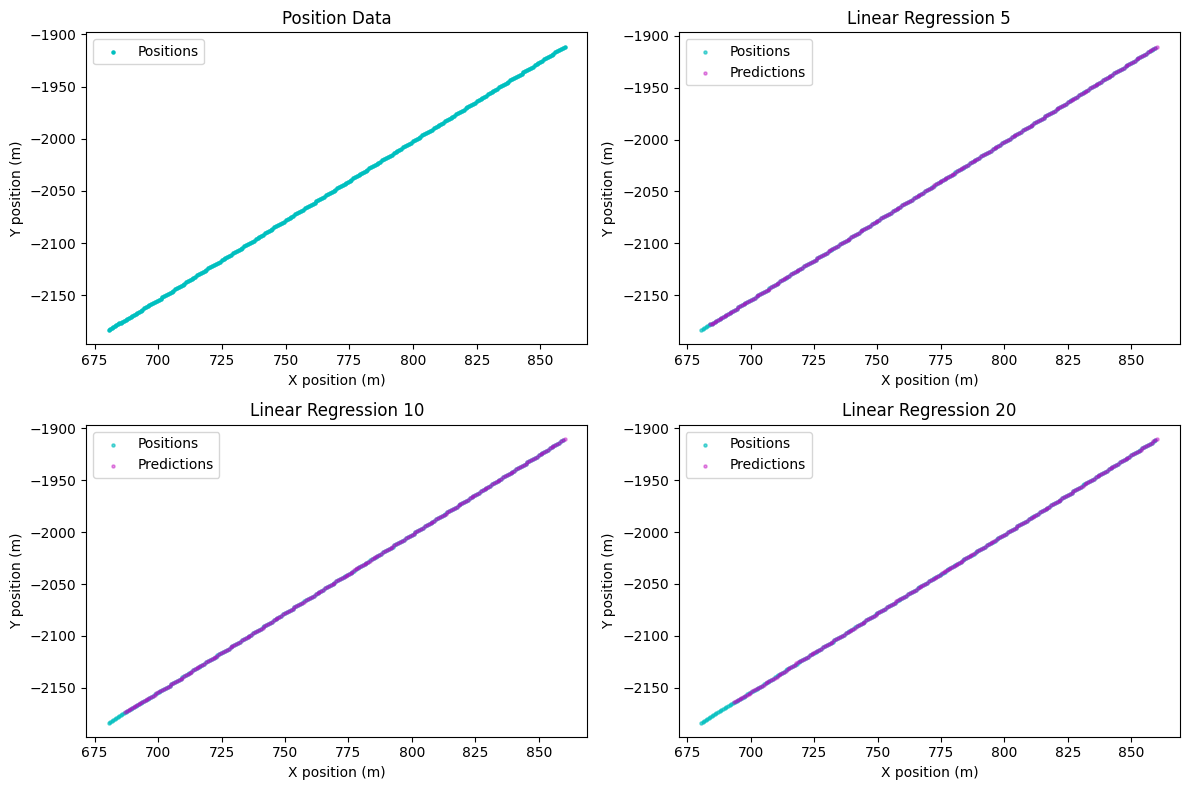

In [68]:
plotScene(0)

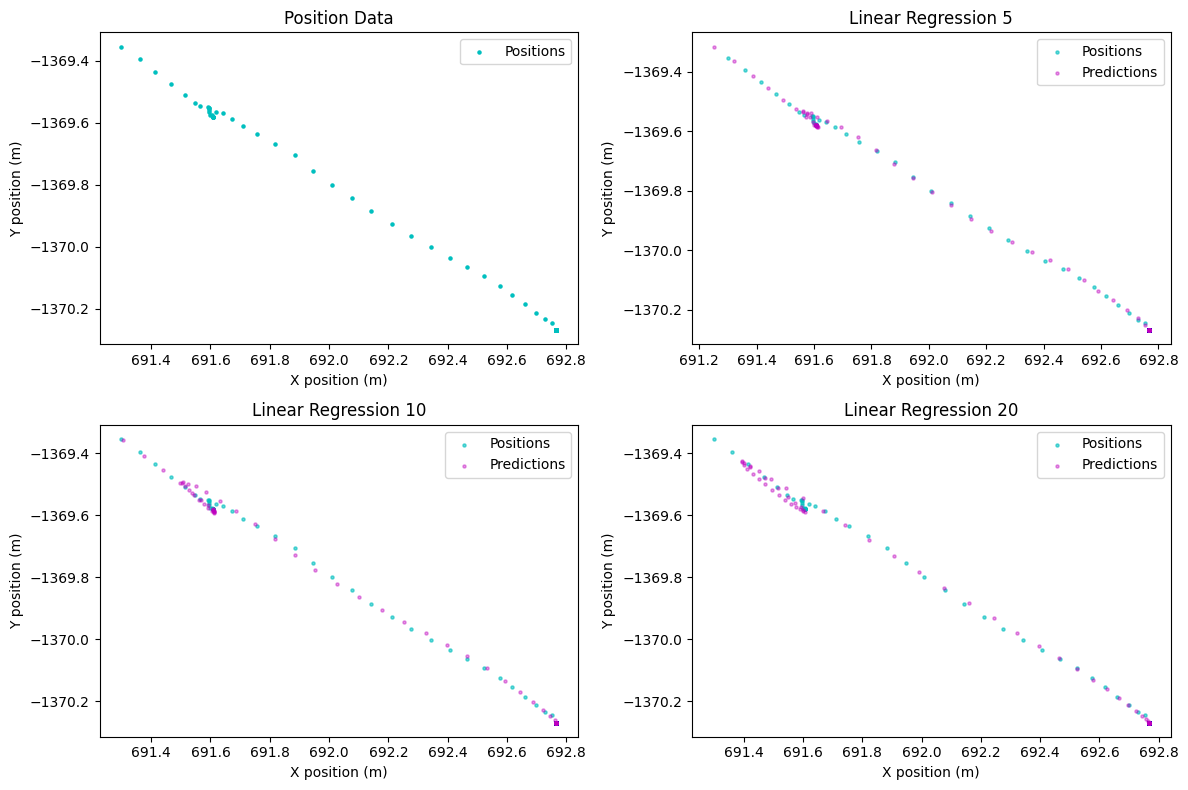

In [69]:
plotScene(5)